# Research Notebook 

## The goal

The goal here is to understand the impact that data gaps have on the L01 pipeline. As seen, the impact of gaps on the telemetry variables result in a widening of the data gaps in the overall Michelson-like variables. I want to try and understand 

* What type of data gap is most impacted
* What generation of TDI is most impactful
* What do the data gap widening depend on? 
* Can I build a distribution of data gaps?

In [5]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import matplotlib.pyplot as plt
from lisaconstants import TROPICALYEAR_J2000DAY
from lisaconstants import c
sys.path.append("../../artifacts_gen/gaps/")  # if gap_widening_utils.py is in the parent directory
from lisa_gap import GapMaskGenerator

sys.path.append("../utility_funcs/")  # if gap_widening_utils.py is in the parent directory
from utility_funcs.multi_gap_utils import (
    mask_TDI_X,
    approx_total_nans_from_nan_blocks_X
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create vague gap function to be used for paper

In [3]:
# Generate the mask with sampling interval 0.25 seconds

# Define the gap function 

# Construct gap class

dt = 10  # seconds
ONE_YEAR = TROPICALYEAR_J2000DAY * 24 * 60 * 60   # seconds
T_obs = 4*ONE_YEAR 
# from gap_mask_gekneration import GapMaskGenerator

sim_t = np.arange(0, T_obs, dt)

gap_definitions_paper = {
    "planned": {
        "Long Duration:": {"rate_per_year": 6, "duration_hr": 40},
        "Medium Duration": {"rate_per_year": 26, "duration_hr": 3.3},
        "Short Duration": {"rate_per_year": 1095, "duration_hr": 0.028}, # 2 second
    },
    "unplanned": {
        "Platform interruptions": {"rate_per_year": 3, "duration_hr": 60},
        "Payload interruptions": {"rate_per_year": 4, "duration_hr": 66},
        "Environmental Interruptions": {"rate_per_year": 30, "duration_hr": 24},
        # "Unknown": {"rate_per_year": 300_000, "duration_hr": 2/(60*60)}, # 2 second
    }
}

# Initialise class with rates, and sampling properties.
generator_w_short_gaps = GapMaskGenerator(
    sim_t,
    dt,
    gap_definitions_paper,
    treat_as_nan=True,
    planseed=11_07_1993,
    unplanseed = 16_12_1997
)

# Generate the mask full of gaps
full_mask_paper_both = generator_w_short_gaps.generate_mask(include_unplanned=True, include_planned=True)
full_mask_paper_planned = generator_w_short_gaps.generate_mask(include_unplanned=False, include_planned=True)
full_mask_paper_unplanned = generator_w_short_gaps.generate_mask(include_unplanned=True, include_planned=False)

extract_summary_both = generator_w_short_gaps.summary(mask = full_mask_paper_both)
extract_summary_planned = generator_w_short_gaps.summary(mask = full_mask_paper_planned)
extract_summary_unplanned = generator_w_short_gaps.summary(mask = full_mask_paper_unplanned)
from pprint import pprint
print("For both planned and unplanned gaps:")
pprint(extract_summary_both['mask_analysis'])
print("")
print("For planned gaps only:")
pprint(extract_summary_planned['mask_analysis'])
print("")
print("For unplanned gaps only:")
pprint(extract_summary_unplanned['mask_analysis'])  


For both planned and unplanned gaps:
{'duty_cycle_percent': np.float64(84.6933),
 'number_of_gap_segments': 3944,
 'total_gap_hours': np.float64(5367.04),
 'total_gap_samples': 1932133}

For planned gaps only:
{'duty_cycle_percent': np.float64(96.1117),
 'number_of_gap_segments': 4339,
 'total_gap_hours': np.float64(1363.38),
 'total_gap_samples': 490815}

For unplanned gaps only:
{'duty_cycle_percent': np.float64(88.1448),
 'number_of_gap_segments': 126,
 'total_gap_hours': np.float64(4156.82),
 'total_gap_samples': 1496454}


In [12]:
import numpy as np
from tqdm import tqdm as tqdm
from pprint import pprint

delay_fraction_integer = (8.3333333/0.25)

# Number of realizations
num_realizations = 2_000

# Initialize storage for statistics
statistics = {
    "both": {"duty_cycle_percent": [], "number_of_gap_segments": [], "total_gap_hours": [], "total_gap_samples": []},
    "planned": {"duty_cycle_percent": [], "number_of_gap_segments": [], "total_gap_hours": [], "total_gap_samples": []},
    "unplanned": {"duty_cycle_percent": [], "number_of_gap_segments": [], "total_gap_hours": [], "total_gap_samples": []},
}

# Simulate 10,000 realizations for each combination
for i in tqdm(range(num_realizations)):
    generator_w_short_gaps = GapMaskGenerator(
    sim_t,
    dt,
    gap_definitions_paper,
    treat_as_nan=True,
    planseed=i,
    unplanseed = i+1
    )
    # Generate masks for each combination
    mask_both = generator_w_short_gaps.generate_mask(include_unplanned=True, include_planned=True)
    mask_planned = generator_w_short_gaps.generate_mask(include_unplanned=False, include_planned=True)
    mask_unplanned = generator_w_short_gaps.generate_mask(include_unplanned=True, include_planned=False)

    # nans_from_planned_unplanned_TDIX2 = approx_total_nans_from_nan_blocks_X(mask_both, delay_fraction_integer, order=45, generation=2)
    # nans_from_planned_TDIX2 = approx_total_nans_from_nan_blocks_X(mask_planned, delay_fraction_integer, order=45, generation=2)
    # nans_from_unplanned_TDIX2 = approx_total_nans_from_nan_blocks_X(mask_unplanned, delay_fraction_integer, order=45, generation=2)

    # Extract summaries for each mask
    summary_both = generator_w_short_gaps.summary(mask=mask_both)["mask_analysis"]
    summary_planned = generator_w_short_gaps.summary(mask=mask_planned)["mask_analysis"]
    summary_unplanned = generator_w_short_gaps.summary(mask=mask_unplanned)["mask_analysis"]
    
    # Store statistics for "both"
    statistics["both"]["duty_cycle_percent"].append(summary_both["duty_cycle_percent"])
    statistics["both"]["number_of_gap_segments"].append(summary_both["number_of_gap_segments"])
    statistics["both"]["total_gap_hours"].append(summary_both["total_gap_hours"])
    statistics["both"]["total_gap_samples"].append(summary_both["total_gap_samples"])
    
    # Store statistics for "planned"
    statistics["planned"]["duty_cycle_percent"].append(summary_planned["duty_cycle_percent"])
    statistics["planned"]["number_of_gap_segments"].append(summary_planned["number_of_gap_segments"])
    statistics["planned"]["total_gap_hours"].append(summary_planned["total_gap_hours"])
    statistics["planned"]["total_gap_samples"].append(summary_planned["total_gap_samples"])
    
    # Store statistics for "unplanned"
    statistics["unplanned"]["duty_cycle_percent"].append(summary_unplanned["duty_cycle_percent"])
    statistics["unplanned"]["number_of_gap_segments"].append(summary_unplanned["number_of_gap_segments"])
    statistics["unplanned"]["total_gap_hours"].append(summary_unplanned["total_gap_hours"])
    statistics["unplanned"]["total_gap_samples"].append(summary_unplanned["total_gap_samples"])

# Convert statistics to numpy arrays for easier analysis
for key in statistics.keys():
    for stat_key in statistics[key].keys():
        statistics[key][stat_key] = np.array(statistics[key][stat_key])



  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [18:51<00:00,  1.77it/s]


In [13]:
# Print summary statistics for each combination
print("Summary Statistics for Both Planned and Unplanned Gaps:")
pprint({
    "Mean Duty Cycle Percent": np.median(statistics["both"]["duty_cycle_percent"]),
    "Mean Number of Gap Segments": np.median(statistics["both"]["number_of_gap_segments"]),
    "Mean Total Gap Hours": np.median(statistics["both"]["total_gap_hours"]),
    "Mean Total Gap Samples": np.median(statistics["both"]["total_gap_samples"]),
})

print("\nSummary Statistics for Planned Gaps Only:")
pprint({
    "Mean Duty Cycle Percent": np.median(statistics["planned"]["duty_cycle_percent"]),
    "Mean Number of Gap Segments": np.median(statistics["planned"]["number_of_gap_segments"]),
    "Mean Total Gap Hours": np.median(statistics["planned"]["total_gap_hours"]),
    "Mean Total Gap Samples": np.median(statistics["planned"]["total_gap_samples"]),
})

print("\nSummary Statistics for Unplanned Gaps Only:")
pprint({
    "Mean Duty Cycle Percent": np.median(statistics["unplanned"]["duty_cycle_percent"]),
    "Mean Number of Gap Segments": np.median(statistics["unplanned"]["number_of_gap_segments"]),
    "Mean Total Gap Hours": np.median(statistics["unplanned"]["total_gap_hours"]),
    "Mean Total Gap Samples": np.median(statistics["unplanned"]["total_gap_samples"]),
})

Summary Statistics for Both Planned and Unplanned Gaps:
{'Mean Duty Cycle Percent': np.float64(84.69915),
 'Mean Number of Gap Segments': np.float64(3945.0),
 'Mean Total Gap Hours': np.float64(5364.98),
 'Mean Total Gap Samples': np.float64(1931392.5)}

Summary Statistics for Planned Gaps Only:
{'Mean Duty Cycle Percent': np.float64(96.1195),
 'Mean Number of Gap Segments': np.float64(4342.0),
 'Mean Total Gap Hours': np.float64(1360.6350000000002),
 'Mean Total Gap Samples': np.float64(489828.5)}

Summary Statistics for Unplanned Gaps Only:
{'Mean Duty Cycle Percent': np.float64(88.08760000000001),
 'Mean Number of Gap Segments': np.float64(125.0),
 'Mean Total Gap Hours': np.float64(4176.87),
 'Mean Total Gap Samples': np.float64(1503673.5)}


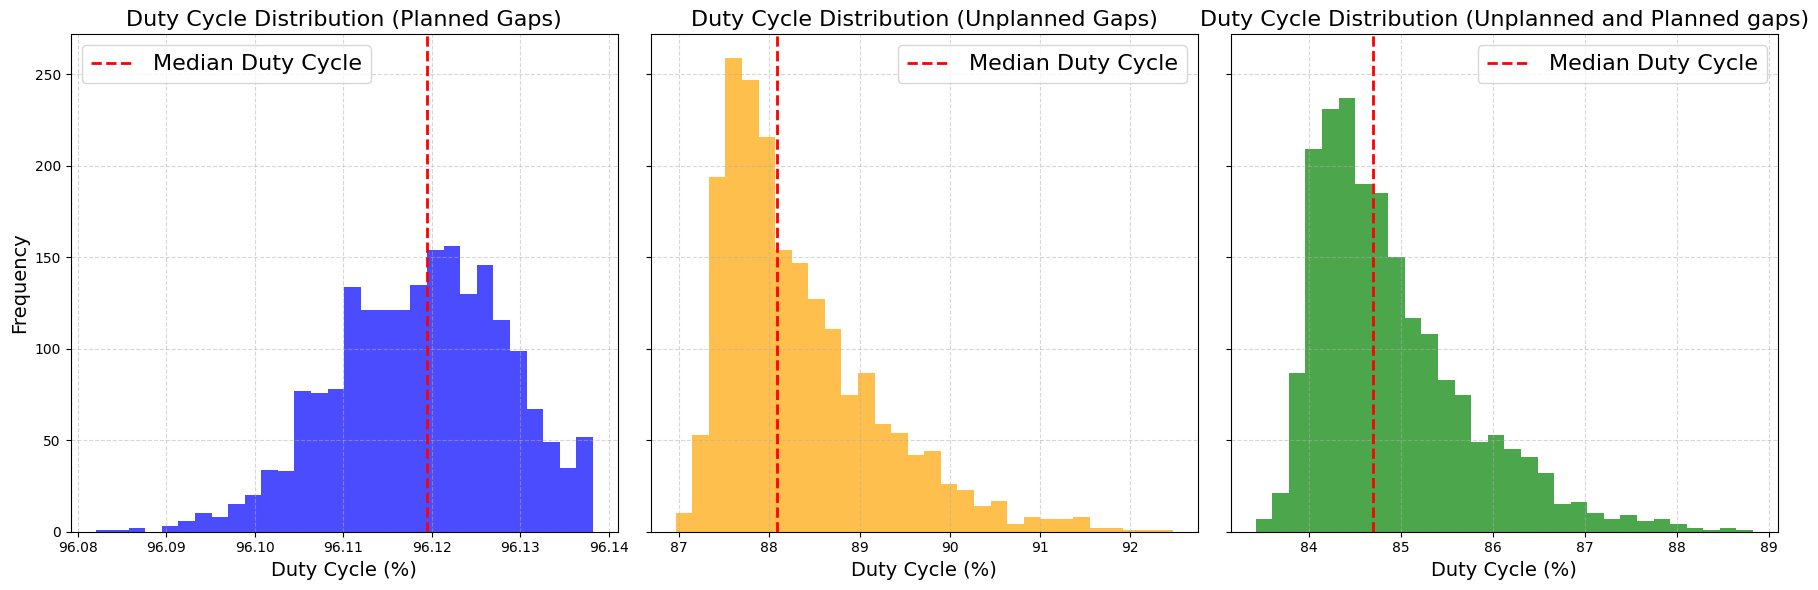

In [14]:
import matplotlib.pyplot as plt

def plot_statistics(ax, data, color):
    mean = np.median(data)
    quantiles = np.percentile(data, [25, 50, 75])
    
    # Plot mean
    ax.axvline(mean, color=color, linestyle="--", linewidth=2, label=f"Mean: {mean:.2f}", c = 'black')
    
    # Plot quantiles
    ax.axvline(quantiles[0], color=color, linestyle=":", linewidth=2, label=f"25th Percentile: {quantiles[0]:.2f}")
    ax.axvline(quantiles[1], color=color, linestyle="-.", linewidth=2, label=f"50th Percentile (Median): {quantiles[1]:.2f}")
    ax.axvline(quantiles[2], color=color, linestyle=":", linewidth=2, label=f"75th Percentile: {quantiles[2]:.2f}")
    
    return mean, quantiles

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)


# Plot for planned gaps
axes[0].hist(statistics["planned"]["duty_cycle_percent"], bins=30, color="blue", alpha=0.7)
axes[0].set_title("Duty Cycle Distribution (Planned Gaps)", fontsize=16)
axes[0].set_xlabel("Duty Cycle (%)", fontsize=14)
axes[0].set_ylabel("Frequency", fontsize=14)
axes[0].grid(True, linestyle="--", alpha=0.5)
axes[0].axvline(x = np.median(statistics["planned"]["duty_cycle_percent"]),c = 'red', linestyle='--', linewidth=2, label='Median Duty Cycle')
    
# Plot for unplanned gaps
axes[1].hist(statistics["unplanned"]["duty_cycle_percent"], bins=30, color="orange", alpha=0.7)
axes[1].set_title("Duty Cycle Distribution (Unplanned Gaps)", fontsize=16)
axes[1].set_xlabel("Duty Cycle (%)", fontsize=14)
axes[1].grid(True, linestyle="--", alpha=0.5)
axes[1].axvline(x = np.median(statistics["unplanned"]["duty_cycle_percent"]),c = 'red', linestyle='--', linewidth=2, label='Median Duty Cycle')

# Plot for both planned and unplanned gaps
axes[2].hist(statistics["both"]["duty_cycle_percent"], bins=30, color="green", alpha=0.7)
axes[2].set_title("Duty Cycle Distribution (Unplanned and Planned gaps)", fontsize=16)
axes[2].set_xlabel("Duty Cycle (%)", fontsize=14)
axes[2].grid(True, linestyle="--", alpha=0.5)
axes[2].axvline(x = np.median(statistics["both"]["duty_cycle_percent"]),c = 'red', linestyle='--', linewidth=2, label='Median Duty Cycle')

for j in range(3):
    axes[j].legend(fontsize=16)

# Adjust layout and show the plot
plt.tight_layout()
# plt.savefig("Duty_Cycle_Distribution_paper.png", dpi=300, bbox_inches='tight')
plt.show()

In [22]:
import numpy as np
from tqdm import tqdm as tqdm
from pprint import pprint

small_dt = 0.25 # seconds
ONE_YEAR = TROPICALYEAR_J2000DAY * 24 * 60 * 60   # seconds
DELAY = (2.5e9/(c*small_dt))
T_obs = 4*ONE_YEAR 

sim_t = np.arange(0, T_obs, small_dt)

# Number of realizations
num_realizations = 600

# Initialize storage for statistics
statistics_small_dt = {
    "both": {
        "duty_cycle_percent": [],
        "number_of_gap_segments": [],
        "total_gap_hours": [],
        "total_gap_samples": [],
        "Gap_Augmentation": [],  # Placeholder for gap augmentation
        "duty_cycle_after_widening_TDIX2": []  # New field for duty cycle after widening
    },
    "planned": {
        "duty_cycle_percent": [],
        "number_of_gap_segments": [],
        "total_gap_hours": [],
        "total_gap_samples": [],
        "Gap_Augmentation": [],  # Placeholder for gap augmentation
        "duty_cycle_after_widening_TDIX2": []  # New field for duty cycle after widening
    },
    "unplanned": {
        "duty_cycle_percent": [],
        "number_of_gap_segments": [],
        "total_gap_hours": [],
        "total_gap_samples": [],
        "Gap_Augmentation": [],  # Placeholder for gap augmentation
        "duty_cycle_after_widening_TDIX2": []  # New field for duty cycle after widening
    },
}

# Simulate 10,000 realizations for each combination
total_samples = len(sim_t)
for i in tqdm(range(num_realizations)):
# Initialise class with rates, and sampling properties.
    generator_w_short_gaps_small_dt = GapMaskGenerator(
        sim_t,
        small_dt,
        gap_definitions_paper,
        treat_as_nan=True,
        planseed=i,
        unplanseed = i+1
    )

    # Generate masks for each combination
    mask_both = generator_w_short_gaps_small_dt.generate_mask(include_unplanned=True, include_planned=True)
    mask_planned = generator_w_short_gaps_small_dt.generate_mask(include_unplanned=False, include_planned=True)
    mask_unplanned = generator_w_short_gaps_small_dt.generate_mask(include_unplanned=True, include_planned=False)

    nans_from_planned_unplanned_TDIX2 = approx_total_nans_from_nan_blocks_X(mask_both, DELAY, order=45, generation=2)
    nans_from_planned_TDIX2 = approx_total_nans_from_nan_blocks_X(mask_planned, DELAY, order=45, generation=2)
    nans_from_unplanned_TDIX2 = approx_total_nans_from_nan_blocks_X(mask_unplanned, DELAY, order=45, generation=2)

    # Compute duty cycle after widening for TDI X2
    duty_cycle_after_widening_both = 100 * (1 - nans_from_planned_unplanned_TDIX2 / total_samples)
    duty_cycle_after_widening_planned = 100 * (1 - nans_from_planned_TDIX2 / total_samples)
    duty_cycle_after_widening_unplanned = 100 * (1 - nans_from_unplanned_TDIX2 / total_samples)
    
    # Extract summaries for each mask
    summary_both = generator_w_short_gaps_small_dt.summary(mask=mask_both)["mask_analysis"]
    summary_planned = generator_w_short_gaps_small_dt.summary(mask=mask_planned)["mask_analysis"]
    summary_unplanned = generator_w_short_gaps_small_dt.summary(mask=mask_unplanned)["mask_analysis"]
    
    # Store statistics for "both"
    statistics_small_dt["both"]["duty_cycle_percent"].append(summary_both["duty_cycle_percent"])
    statistics_small_dt["both"]["number_of_gap_segments"].append(summary_both["number_of_gap_segments"])
    statistics_small_dt["both"]["total_gap_hours"].append(summary_both["total_gap_hours"])
    statistics_small_dt["both"]["total_gap_samples"].append(summary_both["total_gap_samples"])
    statistics_small_dt["both"]["Gap_Augmentation"].append(nans_from_planned_unplanned_TDIX2)
    statistics_small_dt["both"]["duty_cycle_after_widening_TDIX2"].append(duty_cycle_after_widening_both)


    # Store statistics for "planned"
    statistics_small_dt["planned"]["duty_cycle_percent"].append(summary_planned["duty_cycle_percent"])
    statistics_small_dt["planned"]["number_of_gap_segments"].append(summary_planned["number_of_gap_segments"])
    statistics_small_dt["planned"]["total_gap_hours"].append(summary_planned["total_gap_hours"])
    statistics_small_dt["planned"]["total_gap_samples"].append(summary_planned["total_gap_samples"])
    statistics_small_dt["planned"]["Gap_Augmentation"].append(nans_from_planned_TDIX2)
    statistics_small_dt["planned"]["duty_cycle_after_widening_TDIX2"].append(duty_cycle_after_widening_planned)

    # Store statistics for "unplanned"
    statistics_small_dt["unplanned"]["duty_cycle_percent"].append(summary_unplanned["duty_cycle_percent"])
    statistics_small_dt["unplanned"]["number_of_gap_segments"].append(summary_unplanned["number_of_gap_segments"])
    statistics_small_dt["unplanned"]["total_gap_hours"].append(summary_unplanned["total_gap_hours"])
    statistics_small_dt["unplanned"]["total_gap_samples"].append(summary_unplanned["total_gap_samples"])
    statistics_small_dt["unplanned"]["Gap_Augmentation"].append(nans_from_unplanned_TDIX2)
    statistics_small_dt["unplanned"]["duty_cycle_after_widening_TDIX2"].append(duty_cycle_after_widening_unplanned)

# Convert statistics to numpy arrays for easier analysis
for key in statistics_small_dt.keys():
    for stat_key in statistics_small_dt[key].keys():
        statistics_small_dt[key][stat_key] = np.array(statistics_small_dt[key][stat_key])

# Print a summary of the new duty cycle after widening
print("Summary of Duty Cycle After Widening (TDI X2):")
for key in statistics_small_dt.keys():
    print(f"{key.capitalize()} Gaps:")
    print(f" median Duty cycle before widening: {np.median(statistics_small_dt[key]['duty_cycle_percent']):.2f}%")
    print(f"  Median Duty Cycle After Widening: {np.median(statistics_small_dt[key]['duty_cycle_after_widening_TDIX2']):.2f}%")
    print()

100%|██████████| 600/600 [13:33:52<00:00, 81.39s/it]    

Summary of Duty Cycle After Widening (TDI X2):
Both Gaps:
 median Duty cycle before widening: 84.65%
  Median Duty Cycle After Widening: 84.37%

Planned Gaps:
 median Duty cycle before widening: 96.12%
  Median Duty Cycle After Widening: 95.81%

Unplanned Gaps:
 median Duty cycle before widening: 88.02%
  Median Duty Cycle After Widening: 88.01%



In [37]:
(np.median(statistics_small_dt["planned"]["Gap_Augmentation"] - statistics_small_dt["planned"]["total_gap_samples"]) * 0.25 / 60 / 60 / 24)

np.float64(4.485225694444445)

In [38]:
# Now to understand precisely how much data is lost due to the widening of gaps, we can compute the difference between the duty cycle before and after widening.
median_gap_augmentation_both_days = np.median(statistics_small_dt["both"]["Gap_Augmentation"] - statistics_small_dt["both"]["total_gap_samples"]) * 0.25 / 60 / 60 / 24
median_gap_augmentation_planned_days = np.median(statistics_small_dt["planned"]["Gap_Augmentation"] - statistics_small_dt["planned"]["total_gap_samples"]) * 0.25 / 60 / 60 / 24
median_gap_augmentation_unplanned_days = np.median(statistics_small_dt["unplanned"]["Gap_Augmentation"] - statistics_small_dt["unplanned"]["total_gap_samples"]) * 0.25 / 60 / 60 / 24


print("Planned + unplanned gaps = Amount of data lost is ", median_gap_augmentation_both_days)
print("Planned gaps = Amount of data lost is ", median_gap_augmentation_planned_days)
print("unplanned gaps = Amount of data lost is ", median_gap_augmentation_unplanned_days)   

Planned + unplanned gaps = Amount of data lost is  4.072547743055556
Planned gaps = Amount of data lost is  4.485225694444445
unplanned gaps = Amount of data lost is  0.1291232638888889


In [ ]:
import pickle
import os

# Create the directory if it doesn't exist
save_dir = "/Users/ollie.burke/Documents/Work/Code/gaps_tdi/notebooks/data/data_for_large_LISA_like_simulations"
os.makedirs(save_dir, exist_ok=True)

# Save the entire statistics_small_dt dictionary
with open(os.path.join(save_dir, "statistics_small_dt.pkl"), "wb") as f:
    pickle.dump(statistics_small_dt, f)

print(f"Statistics saved to: {os.path.join(save_dir, 'statistics_small_dt.pkl')}")

# Display the dictionary structure and contents
statistics_small_dt

# To load the data
# with open("/Users/ollie.burke/Documents/Work/Code/gaps_tdi/notebooks/data/data_for_large_LISA_like_simulations/statistics_small_dt.pkl", "rb") as f:
#     loaded_statistics = pickle.load(f)

Statistics saved to: /Users/ollie.burke/Documents/Work/Code/gaps_tdi/notebooks/data/data_for_large_LISA_like_simulations/statistics_small_dt.pkl


{'both': {'duty_cycle_percent': array([84.4042, 84.0237, 84.3088, 86.2138, 84.606 , 84.6045, 83.6587,
         85.661 , 83.7827, 84.4865, 84.1367, 84.8929, 85.8656, 84.6039,
         84.1924, 84.1032, 84.195 , 86.0078, 84.5928, 84.5474, 84.1022,
         84.7453, 84.2265, 88.8258, 84.0325, 83.9607, 87.0628, 86.3058,
         84.9548, 84.9973, 84.9988, 85.2732, 84.8828, 85.0293, 84.1284,
         84.3954, 85.1926, 84.6488, 85.279 , 84.4594, 84.0124, 84.3988,
         84.5447, 83.8377, 84.4323, 84.3086, 84.3682, 84.0367, 86.0423,
         85.2994, 84.4562, 86.3329, 84.0184, 84.0008, 84.403 , 85.3422,
         84.0211, 84.5418, 83.8443, 84.3729, 85.5665, 85.7669, 84.2547,
         84.4672, 84.3982, 84.6286, 83.9744, 85.4669, 84.1155, 84.9194,
         86.3572, 84.1787, 84.3289, 84.7804, 85.4374, 85.0902, 84.1033,
         85.3421, 84.7263, 84.9936, 84.2756, 85.7097, 84.1427, 84.1068,
         84.0272, 83.8222, 85.9542, 85.0722, 84.0234, 84.8097, 84.6397,
         85.3819, 86.8429, 84.5644